# Modified 3D PMRNN

## Module Imports

In [1]:
# import numpy as np
import tensorflow as tf
tf.compat.v1.disable_eager_execution()
config = tf.compat.v1.ConfigProto()
config.gpu_options.allow_growth = True
sess = tf.compat.v1.Session(config=config)
import os
import cv2
import import_ipynb
import Utils
# from skimage import util


In [2]:
import numpy as np
print(np.__version__)

1.19.5


In [4]:
import tensorflow as tf

print("TensorFlow version:", tf.__version__)

TensorFlow version: 2.5.0


In [5]:
import pandas as pd
import matplotlib.pyplot as plt

In [6]:
from tensorflow.keras import layers,losses,Sequential,metrics
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Layer
from tensorflow.keras import optimizers 
from tensorflow.keras.optimizers import * 
# from tensorflow.keras.optimizers.experimental import SGD
from tensorflow.image import ssim

In [7]:
import sklearn
print(sklearn.__version__)

1.2.2


In [8]:
from CBAM import ConvolutionBlockAttentionModule

In [9]:
from tensorflow.keras import backend as K

In [10]:
import tensorflow._api.v2.compat.v1 as tf1

## Model Config

In [11]:
CONFIGURATION = {
    "BATCH_SIZE": 16,
    "LEARNING_RATE": 1e-3,
    "OPTIMIZER":'Adam',
    "N_EPOCHS": 2,
    "N_FILTERS": 5,
    "INPUT_SHAPE":(256,256,1),
    "LATENT_SPACE_DIM" : 64,
    "REDUCED_DIMENSION" : 256,
}

In [12]:
CONFIGURATION["OPTIMIZER"]

'Adam'

## reading data

In [13]:
image_data = Utils.read_data("Berea_2d25um_binary.raw")
image_data.shape

(1000, 1000, 1000)

## Voxel extraction 

In [14]:
voxels = Utils.extract_subvolumes(image_data)
voxels.shape

(64, 250, 256, 256, 1)

In [15]:
del image_data

## Loss Functions

In [16]:
def calculate_kl_loss(model):
    def _calculate_kl_loss(*args):
        kld = tf.keras.losses.KLDivergence()
        kl_loss = kld(model.inferenceDistribution,model.learnedDistribution)
        return tf.abs(kl_loss)
    return _calculate_kl_loss

def _calculate_reconstruction_loss(y_target, y_predicted):
    mse = losses.MeanSquaredError()
    reconstruction_loss = mse( y_target, y_predicted )
    return reconstruction_loss

# def _calculate_reconstruction_loss(y_target, y_predicted):
#     ssim_loss = 1 - tf.reduce_mean(ssim(y_target, y_predicted, max_val=1.0))
#     return ssim_loss


def _calculate_porosity_loss(y_target,y_predicted):
    por1 = tf.reduce_mean(y_target,axis=(1, 2))
    por2 = tf.reduce_mean(y_predicted,axis=(1, 2))
    mae = losses.MeanSquaredError()
    return mae(por1,por2)
    

## Model Class

In [17]:
# class EncoderBlock(Model):
#      def __init__(self,n_filter) -> None:
#         super(EncoderBlock,self).__init__()
#         self.conv = layers.Conv2D(n_filter, (3,3) , activation='relu',
#                                padding='same' , name="first_encoder_conv")
#         self.bn = layers.BatchNormalization()
#         self.mp = layers.MaxPooling2D((2,2), padding='same')
            
#     def call(self,X):
#         X = self.conv(X)
#         b = self.bn(X)
#         y = self.mp(b)
#         return y,b

In [18]:
# class DecoderBlock(Model):
#     def __init__(self,n_filter,skip) ->None:
#         super(DecoderBlock,self).__init__()
#         self.convT = layers.Conv2DTranspose(n_filter, (3,3), strides=2, activation='relu'
#                                          , padding='same',name="first_decoder_conv")
#         self.bn = layers.BatchNormalization()
#     def call(self,X):
#         X = self.convT(X)
#         b = self.bn(X)
#         b = layers.Add()([b,skip])
#         return b

In [19]:
# class Encoder(Model):
#     def __init__(self,n_blocks,Filter,latentSpace) -> None:
#         super(Encoder,self).__init__()
#         self.flatten = layers.Flatten()
        
#         self.latentDense = layers.Dense(latentSpace,name ="latent_dense")
#         self.bn = layers.BatchNormalization()
#         self.encBlocks = [EncoderBlock(Filter * (i+1)) for i in range(n_blocks)]
        
#     def call(self,X):
#         for i in range(n_blocks):
#             X = self.encBlocks[i]
#         X = self.flatten(X)
#         X = self.latentDense(X)
#         b = self.bn(X)
#         return b

In [20]:
# 16 * 2 ** (CONFIGURATION["N_FILTERS"]-1)

In [21]:
class Reconstruction():
    """
    Reconstruction represents a Deep Convolutional variational autoencoder architecture
    with mirrored encoder and decoder components.
    """

    def __init__(self,
                 inputShape=CONFIGURATION["INPUT_SHAPE"],
                 latent_space_dim = CONFIGURATION["LATENT_SPACE_DIM"],
                 reducedDimension = CONFIGURATION["REDUCED_DIMENSION"],
                 num_conv_layers = CONFIGURATION["N_FILTERS"],
                 learning_rate = CONFIGURATION["LEARNING_RATE"],
                 batch_size = CONFIGURATION["BATCH_SIZE"],
                 epochs = CONFIGURATION["N_EPOCHS"],
                 opt = CONFIGURATION["OPTIMIZER"],
                )-> None:
        
        
        
        ##### inputs ######
        self.inputShape = inputShape # [256, 256, 1]
        self.latent_space_dim = latent_space_dim # 64
        self.reducedDimension = reducedDimension #256
        self.num_conv_layers = num_conv_layers #5
        self.learning_rate = learning_rate
        self.batch_size = batch_size
        self.epochs = epochs
        self.opt = opt
#         self.optimizer = getattr(optimizers, opt)(lr = learning_rate) 
        self.optimizers = {
            'SGD' : SGD, 
            'RMSprop' : RMSprop,
            'Adagrad' : Adagrad,
            'Adadelta' : Adadelta,
            'Adam' : Adam,
            'Adamax' : Adamax,
            'Nadam' : Nadam,
        }
        self.reshapeDims = self.inputShape[0] // 2**self.num_conv_layers
        self.last_filter = 16 * 2 ** (self.num_conv_layers-1)
        
        ##### Loss weights ######
        self.reconstruction_loss_weight = 1
        self.Kullback_leibler_weight = 0.001
        self.porosity_Loss_weight = 1
        
        self.skipConnections = None

        self.learnedPrior = None
        self.inference = None
        self.Generate = None
        self.Reconstruction=None

        self.skipConnections = []
        
        self.learnedDistribution = None
        self.inferenceDistribution = None
        
        self._build()

    def summary(self):
        self.learnedPrior.summary()
        self.inference.summary()
        self.Generate.summary()
        self.Reconstruction.summary()
    
    def compile(self):
        optimizer = self.optimizers[self.opt](learning_rate=self.learning_rate)
        self.Reconstruction.compile(optimizer=optimizer,
                           loss=self._calculate_combined_loss,
                           metrics=[_calculate_reconstruction_loss,
                                    _calculate_porosity_loss,
                                    calculate_kl_loss(self)],
                             experimental_run_tf_function=False)
    
    def train(self, inputs1,inputs2):
        return self.Reconstruction.fit(x=[inputs1,inputs2],
                       y=inputs2,
                       batch_size=self.batch_size,
                       epochs=self.epochs,
                       )
    
#     def save(self, save_folder="."):
#         self._create_folder_if_it_doesnt_exist(save_folder)
#         self._save_parameters(save_folder)
#         self._save_weights(save_folder)

#     def load_weights(self, weights_path):
#         self.model.load_weights(weights_path)


#      @classmethod
#     def load(cls, save_folder="."):
#         parameters_path = os.path.join(save_folder, "parameters.pkl")
#         with open(parameters_path, "rb") as f:
#             parameters = pickle.load(f)
#         autoencoder = Reconstruction(*parameters)
#         weights_path = os.path.join(save_folder, "weights.h5")
#         autoencoder.load_weights(weights_path)
#         return autoencoder

    def _calculate_combined_loss(self, y_target, y_predicted):
        
        
        reconstruction_loss = _calculate_reconstruction_loss(y_target,y_predicted)
        kl_loss = calculate_kl_loss(self)(self.inferenceDistribution, self.learnedDistribution)
        porisity_loss = _calculate_porosity_loss(y_target, y_predicted)
        combined_loss = self.reconstruction_loss_weight * reconstruction_loss\
                                                         + kl_loss * self.Kullback_leibler_weight\
                                                         + porisity_loss * self.porosity_Loss_weight
        return combined_loss
    


    def _build(self):
        self._build_inference(self.num_conv_layers)
        self._build_learned_prior(self.num_conv_layers)
        self._build_generate(self.num_conv_layers)
        self._build_reconstruction()
    
    
    
    ######  inference ########
        
    def _build_inference(self,num_conv_layers):
        inference_input = layers.Input(shape=self.inputShape, name="inference_input")
        
        ### ------------------------------------ Encoder ---------------------------------------------
        
        x = inference_input
        for i in range(num_conv_layers):
            conv = layers.Conv2D(16 * 2 ** i, (3, 3), activation='relu', padding='same', name=f"encoder_conv_{i+1}")(x)
            bn = layers.BatchNormalization()(conv)
            mp = layers.MaxPooling2D((2, 2), padding='same')(bn)
            x = mp
   
        
        flattened = layers.Flatten()(x)
        
        latentDense = layers.Dense(self.reducedDimension,name ="latent_dense")(flattened)
        conv_out = layers.BatchNormalization()(latentDense)
        
    
        reshaped = layers.Reshape((1, self.reducedDimension))(conv_out)
        inferenceDist = layers.LSTM(self.latent_space_dim, return_sequences=True, name="inference_LSTM")(reshaped)
       
        self.inference = Model(inference_input, inferenceDist, name="inference")
        
        
    ######   learned prior ########
        
    def _build_learned_prior(self,num_conv_layers):
        learned_input = layers.Input(shape=self.inputShape, name="learned_prior_input")
        
        ### ------------------------------------ Encoder ---------------------------------------------
        
        x = learned_input
        for i in range(num_conv_layers):
            conv = layers.Conv2D(16 * 2 ** i, (3, 3), activation='relu', padding='same', name=f"encoder_conv_{i+1}")(x)
            bn = layers.BatchNormalization()(conv)
            mp = layers.MaxPooling2D((2, 2), padding='same')(bn)
            x = mp
        
        flattened = layers.Flatten()(x)
        
        latentDense = layers.Dense(self.reducedDimension,name ="latent_dense")(flattened)
        conv_out = layers.BatchNormalization()(latentDense)
        
        
        
        reshaped = layers.Reshape((1, self.reducedDimension))(conv_out)
        learned_dist = layers.LSTM(self.latent_space_dim, return_sequences=True,name="learned_LSTM")(reshaped)
        self.learnedPrior = Model(learned_input, learned_dist, name="learned_prior")
    
    #### generate ######
    
    def _build_generate(self,num_conv_layers):
        

        
        input_generate = layers.Input(shape=self.inputShape, name="generate_input")
        learnedDist = layers.Input(shape=(1,self.latent_space_dim), name="gen_learned_input")
        
        ### ------------------------------------ Encoder ---------------------------------------------
        
        x = input_generate
        for i in range(num_conv_layers):
            conv = layers.Conv2D(16 * 2 ** i, (3, 3), activation='relu', padding='same', name=f"encoder_conv_{i+1}")(x)
            bn = layers.BatchNormalization()(conv)
            mp = layers.MaxPooling2D((2, 2), padding='same')(bn)
            x = mp
            self.skipConnections.append(bn)

        
        flattened = layers.Flatten()(x)
        
        latentDense = layers.Dense(self.reducedDimension,name ="latent_dense")(flattened)
        conv_out = layers.BatchNormalization()(latentDense)
        
        temp = layers.Reshape(( 1 ,self.reducedDimension ))(conv_out)
        
        concated_input = layers.Concatenate(axis=-1)([temp,learnedDist])
        
        reshaped = layers.Reshape((1, self.reducedDimension + self.latent_space_dim))(concated_input)
        
        generated = layers.LSTM(self.reducedDimension, return_sequences=True,name="generate_LSTM")(reshaped)
        
        ### ------------------------------------ Decoder ---------------------------------------------
        
        upDense = layers.Dense(self.reshapeDims*self.reshapeDims*self.last_filter,name="up_dense")(generated)
        batchNorm_7 = layers.BatchNormalization()(upDense)
        
        reshapedUp = layers.Reshape((self.reshapeDims,self.reshapeDims,self.last_filter))(batchNorm_7)
        
        
        
        generated = reshapedUp
        for i in reversed(range(num_conv_layers)):
            convT = layers.Conv2DTranspose(16 * 2 ** i, (3, 3), strides=2, activation='relu',
                                           padding='same', name=f"decoder_conv_{i+1}")(generated)
            bn = layers.BatchNormalization()(convT)
            skip_conn = self.skipConnections.pop()
            bn = layers.Add()([bn, skip_conn])
            generated = ConvolutionBlockAttentionModule()(bn)
        
        
        gen_out = layers.Conv2DTranspose(1, (3,3), activation='sigmoid', padding='same')(generated)
        
        self.Generate = Model([input_generate,learnedDist], gen_out, name="generate")
        
        
        
    def _build_reconstruction(self):
        input_learned = layers.Input(shape=self.inputShape, name="learned_input")
        input_inference = layers.Input(shape=self.inputShape, name="inference_input")
        

        
        self.learnedDistribution = self.learnedPrior(input_learned)
        self.inferenceDistribution = self.inference(input_inference)
        gen_out = self.Generate([input_learned,self.learnedDistribution])
        
        self.Reconstruction = Model([input_learned,input_inference],gen_out,name="reconstuction")

In [22]:
optimizers = {
            'SGD' : SGD, 
            'RMSprop' : RMSprop,
            'Adagrad' : Adagrad,
            'Adadelta' : Adadelta,
            'Adam' : Adam,
            'Adamax' : Adamax,
            'Nadam' : Nadam,
        }
optimizers['SGD']

tensorflow.python.keras.optimizer_v2.gradient_descent.SGD

## TensorFlow gpu setup

In [23]:
device = tf.config.list_physical_devices("GPU")
print(device)
tf.config.experimental.set_memory_growth(device[0],True)

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]


In [24]:
os.environ['TF_FORCE_GPU_ALLOW_GROWTH'] = 'true'

In [25]:
tf.keras.backend.clear_session()

## Model creation

In [26]:
reconstruction = Reconstruction()
reconstruction.summary()
reconstruction.compile()

Instructions for updating:
Colocations handled automatically by placer.
Model: "learned_prior"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
learned_prior_input (InputLa [(None, 256, 256, 1)]     0         
_________________________________________________________________
encoder_conv_1 (Conv2D)      (None, 256, 256, 16)      160       
_________________________________________________________________
batch_normalization_6 (Batch (None, 256, 256, 16)      64        
_________________________________________________________________
max_pooling2d_5 (MaxPooling2 (None, 128, 128, 16)      0         
_________________________________________________________________
encoder_conv_2 (Conv2D)      (None, 128, 128, 32)      4640      
_________________________________________________________________
batch_normalization_7 (Batch (None, 128, 128, 32)      128       
_______________________________________________

## train and test data extraction

In [27]:
X_train = voxels[:-6]
X_test = voxels[-6:]

In [28]:
len(X_train)

58

In [29]:
import numpy as np
print(np.__version__)

1.19.5


In [30]:
del voxels

## Creating model input

In [31]:
learnedVoxels = []
inferenceVoxels = []
for voxel in X_train:
    learnedVoxels.append(voxel[:-1])
    inferenceVoxels.append(voxel[1:])

# learnedVoxels = np.array(learnedVoxels)
# inferenceVoxels = np.array(inferenceVoxels)

In [38]:
import sys
from mealpy.swarm_based import GWO
from sklearn.preprocessing import LabelEncoder


OPT_ENCODER = LabelEncoder()
OPT_ENCODER.fit(['SGD', 'RMSprop', 'Adagrad', 'Adadelta', 'Adam', 'Adamax', 'Nadam'])


def decode_solution(solution):
    batch_size = 2**int(solution[0])
    
    learning_rate = solution[1]
    
    opt_int = int(solution[2])
    opt = OPT_ENCODER.inverse_transform([opt_int])[0]
    
    epoch = 10 *int(solution[3])
    
    num_filters = int(solution[4])
    
    latent_space_dim = 2**int(solution[5])
    
    reduced_dim = 2**int(solution[6])
    
    return [batch_size,learning_rate,opt,epoch,num_filters,latent_space_dim,reduced_dim]


def objective_function(solution):
    batch_size,learning_rate,opt,epoch,num_filters,latent_space_dim ,reduced_dim = decode_solution(solution)
    reconstruction = Reconstruction(inputShape=CONFIGURATION["INPUT_SHAPE"],
                                     latent_space_dim = latent_space_dim,
                                     reducedDimension = reduced_dim,
                                     num_conv_layers = num_filters,
                                     learning_rate = learning_rate,
                                     batch_size = batch_size,
                                     epochs = epoch,
                                     opt = opt,
                                   )
#     reconstruction.summary()
    reconstruction.compile()
    
    
    histories = []
    for i in range(len(learnedVoxels)):
        print(f"currently working one voxel : {i +1}, voxels left : {len(learnedVoxels)-(i+1)} ")
        histories.append(reconstruction.train(learnedVoxels[i],inferenceVoxels[i]))
    
    
    return histories[-1].history['loss'][-1]
    
    

LB = [3    , 0.001 , 0   , 2      ,  4  ,  6    , 7 ]
UB = [5.99 , 0.01  , 6.99, 4.99  ,  8.99,  8.99 , 9.99 ]

problem_dict = {
    "fit_func": objective_function,
    "lb": LB,
    "ub": UB,
    "minmax": "min",
    "verbose":True,
}

model = GWO.BaseGWO(problem_dict,epoch=5,pop_size=50)
model.solve()
print(f"Best solution : {model.solution[0]}")
batch_size,learning_rate,opt,epoch,num_filters,latent_space_dim ,reduced_dim = decode_solution(model.solution[0])
print(f"Batch size : {batch_size}, learning_rate : {learning_rate}, opt : {opt}, epoch : {epoch}, num_filters : {num_filters}, latent_space_dim : {latent_space_dim}, reduced_dim : {reduced_dim}")
    

currently working one voxel : 1, voxels left : 57 
Train on 249 samples
Epoch 1/30
249/249 [==============================] - 15s 62ms/sample - loss: 0.0727 - _calculate_reconstruction_loss: 0.0440 - _calculate_porosity_loss: 0.0048 - _calculate_kl_loss: 22.6561
Epoch 2/30
249/249 [==============================] - 9s 36ms/sample - loss: 0.0459 - _calculate_reconstruction_loss: 0.0262 - _calculate_porosity_loss: 1.3356e-04 - _calculate_kl_loss: 18.9626
Epoch 3/30
249/249 [==============================] - 9s 36ms/sample - loss: 0.0425 - _calculate_reconstruction_loss: 0.0247 - _calculate_porosity_loss: 1.1757e-04 - _calculate_kl_loss: 17.0157
Epoch 4/30
249/249 [==============================] - 9s 36ms/sample - loss: 0.0383 - _calculate_reconstruction_loss: 0.0231 - _calculate_porosity_loss: 9.8942e-05 - _calculate_kl_loss: 14.7887
Epoch 5/30
249/249 [==============================] - 9s 36ms/sample - loss: 0.0334 - _calculate_reconstruction_loss: 0.0211 - _calculate_porosity_loss: 9.

Epoch 10/30
249/249 [==============================] - 9s 38ms/sample - loss: 0.0098 - _calculate_reconstruction_loss: 0.0088 - _calculate_porosity_loss: 7.2207e-06 - _calculate_kl_loss: 0.9355
Epoch 11/30
249/249 [==============================] - 9s 38ms/sample - loss: 0.0093 - _calculate_reconstruction_loss: 0.0084 - _calculate_porosity_loss: 5.6247e-06 - _calculate_kl_loss: 0.8626
Epoch 12/30
249/249 [==============================] - 9s 38ms/sample - loss: 0.0088 - _calculate_reconstruction_loss: 0.0081 - _calculate_porosity_loss: 5.2388e-06 - _calculate_kl_loss: 0.7581
Epoch 13/30
249/249 [==============================] - 9s 38ms/sample - loss: 0.0085 - _calculate_reconstruction_loss: 0.0078 - _calculate_porosity_loss: 5.0362e-06 - _calculate_kl_loss: 0.8143
Epoch 14/30
249/249 [==============================] - 9s 38ms/sample - loss: 0.0086 - _calculate_reconstruction_loss: 0.0075 - _calculate_porosity_loss: 5.0631e-06 - _calculate_kl_loss: 1.0777
Epoch 15/30
249/249 [=========

249/249 [==============================] - 9s 37ms/sample - loss: 0.0056 - _calculate_reconstruction_loss: 0.0050 - _calculate_porosity_loss: 3.2705e-06 - _calculate_kl_loss: 0.5765
Epoch 22/30
249/249 [==============================] - 9s 37ms/sample - loss: 0.0058 - _calculate_reconstruction_loss: 0.0050 - _calculate_porosity_loss: 4.1140e-06 - _calculate_kl_loss: 0.7906
Epoch 23/30
249/249 [==============================] - 9s 37ms/sample - loss: 0.0057 - _calculate_reconstruction_loss: 0.0049 - _calculate_porosity_loss: 3.7243e-06 - _calculate_kl_loss: 0.8778
Epoch 24/30
249/249 [==============================] - 9s 37ms/sample - loss: 0.0052 - _calculate_reconstruction_loss: 0.0046 - _calculate_porosity_loss: 2.7986e-06 - _calculate_kl_loss: 0.6054
Epoch 25/30
249/249 [==============================] - 9s 37ms/sample - loss: 0.0051 - _calculate_reconstruction_loss: 0.0046 - _calculate_porosity_loss: 2.2118e-06 - _calculate_kl_loss: 0.6071
Epoch 26/30
249/249 [=====================

249/249 [==============================] - 9s 38ms/sample - loss: 0.0185 - _calculate_reconstruction_loss: 0.0175 - _calculate_porosity_loss: 2.2873e-05 - _calculate_kl_loss: 0.8584
Epoch 3/30
249/249 [==============================] - 9s 38ms/sample - loss: 0.0146 - _calculate_reconstruction_loss: 0.0140 - _calculate_porosity_loss: 1.7601e-05 - _calculate_kl_loss: 0.6115
Epoch 4/30
249/249 [==============================] - 9s 38ms/sample - loss: 0.0129 - _calculate_reconstruction_loss: 0.0120 - _calculate_porosity_loss: 1.1759e-05 - _calculate_kl_loss: 0.8499
Epoch 5/30
249/249 [==============================] - 9s 38ms/sample - loss: 0.0116 - _calculate_reconstruction_loss: 0.0108 - _calculate_porosity_loss: 1.1510e-05 - _calculate_kl_loss: 0.8153
Epoch 6/30
249/249 [==============================] - 9s 38ms/sample - loss: 0.0106 - _calculate_reconstruction_loss: 0.0099 - _calculate_porosity_loss: 9.0872e-06 - _calculate_kl_loss: 0.7270
Epoch 7/30
249/249 [==========================

Epoch 14/30
249/249 [==============================] - 9s 37ms/sample - loss: 0.0074 - _calculate_reconstruction_loss: 0.0065 - _calculate_porosity_loss: 3.2915e-06 - _calculate_kl_loss: 0.8819
Epoch 15/30
249/249 [==============================] - 9s 38ms/sample - loss: 0.0071 - _calculate_reconstruction_loss: 0.0063 - _calculate_porosity_loss: 2.8559e-06 - _calculate_kl_loss: 0.8179
Epoch 16/30
249/249 [==============================] - 9s 38ms/sample - loss: 0.0067 - _calculate_reconstruction_loss: 0.0061 - _calculate_porosity_loss: 3.3209e-06 - _calculate_kl_loss: 0.6372
Epoch 17/30
249/249 [==============================] - 10s 38ms/sample - loss: 0.0065 - _calculate_reconstruction_loss: 0.0059 - _calculate_porosity_loss: 3.8606e-06 - _calculate_kl_loss: 0.5768
Epoch 18/30
249/249 [==============================] - 10s 40ms/sample - loss: 0.0063 - _calculate_reconstruction_loss: 0.0058 - _calculate_porosity_loss: 2.2591e-06 - _calculate_kl_loss: 0.6044
Epoch 19/30
249/249 [=======

249/249 [==============================] - 10s 39ms/sample - loss: 0.0057 - _calculate_reconstruction_loss: 0.0051 - _calculate_porosity_loss: 2.8220e-06 - _calculate_kl_loss: 0.5879
Epoch 26/30
249/249 [==============================] - 10s 39ms/sample - loss: 0.0058 - _calculate_reconstruction_loss: 0.0051 - _calculate_porosity_loss: 1.8357e-06 - _calculate_kl_loss: 0.7519
Epoch 27/30
249/249 [==============================] - 10s 38ms/sample - loss: 0.0056 - _calculate_reconstruction_loss: 0.0051 - _calculate_porosity_loss: 2.9472e-06 - _calculate_kl_loss: 0.6123
Epoch 28/30
249/249 [==============================] - 10s 38ms/sample - loss: 0.0053 - _calculate_reconstruction_loss: 0.0048 - _calculate_porosity_loss: 2.8096e-06 - _calculate_kl_loss: 0.5251
Epoch 29/30
249/249 [==============================] - 10s 40ms/sample - loss: 0.0053 - _calculate_reconstruction_loss: 0.0047 - _calculate_porosity_loss: 2.3832e-06 - _calculate_kl_loss: 0.6414
Epoch 30/30
249/249 [================

249/249 [==============================] - 9s 37ms/sample - loss: 0.0103 - _calculate_reconstruction_loss: 0.0098 - _calculate_porosity_loss: 9.0794e-06 - _calculate_kl_loss: 0.5399
Epoch 7/30
249/249 [==============================] - 9s 37ms/sample - loss: 0.0098 - _calculate_reconstruction_loss: 0.0090 - _calculate_porosity_loss: 9.1086e-06 - _calculate_kl_loss: 0.7597
Epoch 8/30
249/249 [==============================] - 9s 37ms/sample - loss: 0.0090 - _calculate_reconstruction_loss: 0.0085 - _calculate_porosity_loss: 6.7660e-06 - _calculate_kl_loss: 0.6127
Epoch 9/30
249/249 [==============================] - 9s 37ms/sample - loss: 0.0087 - _calculate_reconstruction_loss: 0.0080 - _calculate_porosity_loss: 3.8373e-06 - _calculate_kl_loss: 0.7674
Epoch 10/30
249/249 [==============================] - 9s 37ms/sample - loss: 0.0083 - _calculate_reconstruction_loss: 0.0076 - _calculate_porosity_loss: 6.4875e-06 - _calculate_kl_loss: 0.7091
Epoch 11/30
249/249 [========================

Epoch 18/30
249/249 [==============================] - 9s 38ms/sample - loss: 0.0065 - _calculate_reconstruction_loss: 0.0059 - _calculate_porosity_loss: 2.8179e-06 - _calculate_kl_loss: 0.5792
Epoch 19/30
249/249 [==============================] - 9s 38ms/sample - loss: 0.0064 - _calculate_reconstruction_loss: 0.0058 - _calculate_porosity_loss: 3.7592e-06 - _calculate_kl_loss: 0.6068
Epoch 20/30
249/249 [==============================] - 9s 38ms/sample - loss: 0.0064 - _calculate_reconstruction_loss: 0.0057 - _calculate_porosity_loss: 3.1870e-06 - _calculate_kl_loss: 0.7293
Epoch 21/30
249/249 [==============================] - 9s 37ms/sample - loss: 0.0062 - _calculate_reconstruction_loss: 0.0056 - _calculate_porosity_loss: 4.8123e-06 - _calculate_kl_loss: 0.6917
Epoch 22/30
249/249 [==============================] - 9s 38ms/sample - loss: 0.0060 - _calculate_reconstruction_loss: 0.0054 - _calculate_porosity_loss: 4.2340e-06 - _calculate_kl_loss: 0.6679
Epoch 23/30
249/249 [=========

249/249 [==============================] - 9s 37ms/sample - loss: 0.0053 - _calculate_reconstruction_loss: 0.0046 - _calculate_porosity_loss: 1.9726e-06 - _calculate_kl_loss: 0.7191
Epoch 30/30
249/249 [==============================] - 9s 37ms/sample - loss: 0.0050 - _calculate_reconstruction_loss: 0.0046 - _calculate_porosity_loss: 1.6815e-06 - _calculate_kl_loss: 0.4824
currently working one voxel : 12, voxels left : 46 
Train on 249 samples
Epoch 1/30
249/249 [==============================] - 9s 37ms/sample - loss: 0.0304 - _calculate_reconstruction_loss: 0.0298 - _calculate_porosity_loss: 3.5509e-05 - _calculate_kl_loss: 0.6589
Epoch 2/30
249/249 [==============================] - 9s 37ms/sample - loss: 0.0218 - _calculate_reconstruction_loss: 0.0211 - _calculate_porosity_loss: 4.3453e-05 - _calculate_kl_loss: 0.7214
Epoch 3/30
249/249 [==============================] - 9s 37ms/sample - loss: 0.0173 - _calculate_reconstruction_loss: 0.0166 - _calculate_porosity_loss: 1.7177e-05 -

## Training the model

In [57]:
histories = []
for i in range(len(learnedVoxels)):
    print(f"currently working one voxel : {i +1}, voxels left : {len(learnedVoxels)-(i+1)} ")
    histories.append(reconstruction.train(learnedVoxels[i],inferenceVoxels[i]))

currently working one voxel : 1, voxels left : 1 
Train on 249 samples
Epoch 1/2
249/249 [==============================] - 9s 37ms/sample - loss: 0.1356 - _calculate_reconstruction_loss: 0.0850 - _calculate_porosity_loss: 0.0191 - _calculate_kl_loss: 29.7727
Epoch 2/2
249/249 [==============================] - 7s 27ms/sample - loss: 0.0635 - _calculate_reconstruction_loss: 0.0359 - _calculate_porosity_loss: 0.0022 - _calculate_kl_loss: 25.2190
currently working one voxel : 2, voxels left : 0 
Train on 249 samples
Epoch 1/2
249/249 [==============================] - 7s 27ms/sample - loss: 0.0590 - _calculate_reconstruction_loss: 0.0304 - _calculate_porosity_loss: 0.0011 - _calculate_kl_loss: 27.2856
Epoch 2/2
249/249 [==============================] - 7s 27ms/sample - loss: 0.0510 - _calculate_reconstruction_loss: 0.0268 - _calculate_porosity_loss: 4.9076e-04 - _calculate_kl_loss: 23.6723


In [60]:
print(histories[-1].history['loss'][-1])

0.051049211926488994


## Testing the model

In [26]:

first  = X_test[0]
Topredict = first[1:]
test = first[:-1]


In [22]:
# predicted = []


# # for i in range(10):
# predicted = reconstruction.Generate.predict([test,Topredict])
# # predicted.append(nextLayer)
# # #     inputLayer = nextLayer
# # predicted.append()

In [23]:
# len(predicted)

In [ ]:
# sess = tf.compat.v1.Session()
# predictedValues = []
# for i in range (10):
# # Evaluate the tensor and get its value
#     predictedValues.append(sess.run(predicted[i+1]))


# # Close the session
# sess.close()

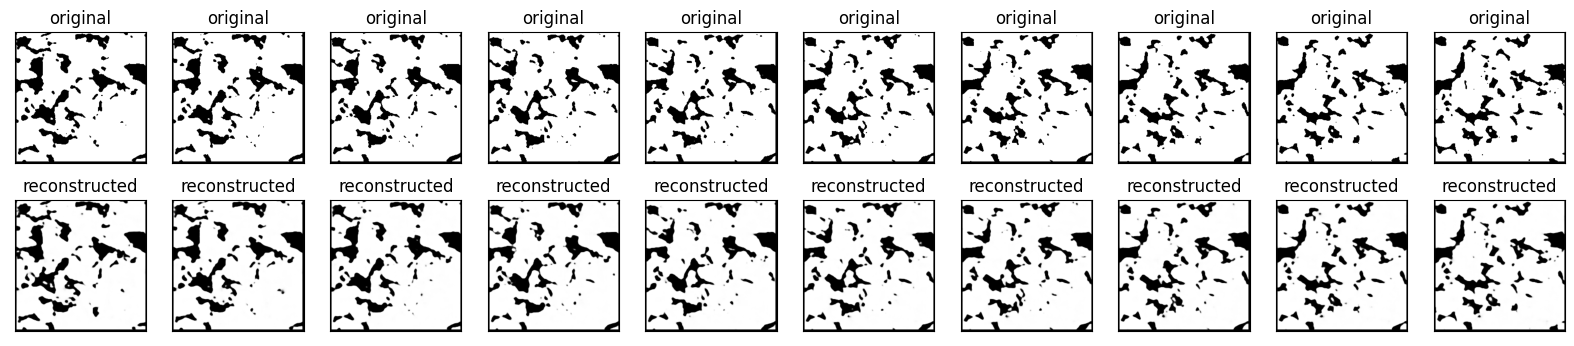

In [26]:
n = 10

plt.figure(figsize=(20,4))
for i in range(n):
    # original
    ax = plt.subplot(2,n,i+1)
    plt.imshow(Topredict[i].astype("float32"))
    plt.title('original')
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)

    # reconstructed
    ax = plt.subplot(2,n,i+1+n)
    plt.imshow(predicted[i].astype("float32"))
    plt.title('reconstructed')
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)

In [27]:
testing = []
inputLayer = first[0]
# for i in range(len(first)-1):
for i in range(10):

    learned = reconstruction.learnedPrior(inputLayer.reshape(1,256,256,1))
    testing.append(reconstruction.Generate.predict([inputLayer.reshape(1,256,256,1),learned],steps=1))
    inputLayer = testing[-1]

D:\Anaconda\envs\PFE\lib\site-packages\tensorflow\python\keras\engine\training.py:2426: UserWarning: `Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.
  warnings.warn('`Model.state_updates` will be removed in a future version. '


In [28]:
len(testing)

10

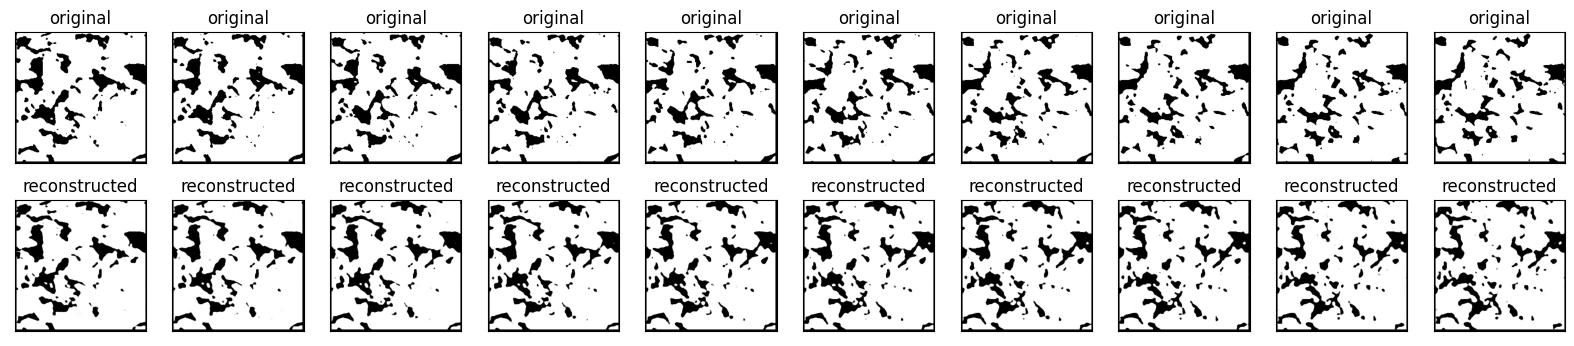

In [29]:
n = 10

plt.figure(figsize=(20,4))
for i in range(n):
    # original
    ax = plt.subplot(2,n,i+1)
    plt.imshow(Topredict[i].astype("float32"))
    plt.title('original')
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)

    # reconstructed
    ax = plt.subplot(2,n,i+1+n)
    plt.imshow(testing[i].reshape(256,256,1))
    plt.title('reconstructed')
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)

In [30]:
reconstruction.Generate.save('reconstruction_10batch_10epochs.h5')

D:\Anaconda\envs\PFE\lib\site-packages\tensorflow\python\keras\utils\generic_utils.py:494: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  warnings.warn('Custom mask layers require a config and must override '


NotImplementedError: Layers with arguments in `__init__` must override `get_config`.

In [31]:
file_path = "reconstructed.raw"
testing.insert(0, first[0].reshape(1,256,256,1))
print(len(testing))



250


In [33]:
final = np.array(testing,np.float32).reshape(250,256,256)
final.shape

(250, 256, 256)

In [34]:
file_path = "my_array.npy"
np.save("file", final)

In [35]:
final.tofile(file_path)

In [53]:
Volume = np.fromfile(file_path, dtype=np.uint8)
Volume = Volume.reshape(250,256,256)
Volume.shape

(250, 256, 256)